# Wine Chromatic Profile Prediction Project
### Group 22 

___
### INTRODUCTION
___

This project seeks to answer the following question:   
**"Can we predict the color of wine using its physiochemical properties, such as acidity, sugar content, and alcohol level?"** 

To answer this question, we are using a [data set](https://archive.ics.uci.edu/dataset/186/wine+quality) from the Vinho Verde region in Portugal . These datasets, publicly available through the UCI Machine Learning Repository, include 11 physiochemical attributes for each wine sample—such as fixed acidity, volatile acidity, pH, and alcohol content—along with a sensory-based quality score ranging from 0 to 10. The red wine dataset contains 1,599 samples, while the white wine dataset includes 4,898 samples, enabling a comprehensive analysis across different types of wine.

The ability to accurately classify wine color using machine learning could offer several advantages. For instance, winemakers and researchers could efficiently analyze large datasets, identify trends, and optimize production processes. Furthermore, consumers or wine retailers might use such tools to assess or verify wine characteristics without requiring advanced laboratory equipment. By developing a robust classification model, we aim to contribute to the wine industry’s growing adoption of data-driven methods, enhancing efficiency and accuracy in identifying and categorizing wines. Ultimately, this approach could lead to scalable, reproducible, and cost-effective methods for wine analysis.

___  
### METHODS
___

The code for this analysis and report is available on GitHub: <https://github.com/UBC-MDS/DSCI522-2425-22-wine-quality.git>.

The dataset was initially loaded into a single dataframe, and an exploratory data analysis was conducted to understand the distribution of features. This included checking for class imbalance in the target variable, examining collinearity between input features, and identifying the types of features present in the dataset. This analysis informed decisions regarding feature encoding in subsequent steps.

In [37]:
import pandas as pd 
import numpy as np 
import altair as alt
import altair_ally as aly
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split

### Exploratory Data Analysis

To examine the data, we first looked at the data types of columns we will be working with: all features are numeric without any null values. Next, in order to select features for modelling, we examined each feature's distribution in respect to color and feaature correlations.

In [28]:
# loading data 
wine_quality = fetch_ucirepo(id=186) 
wine = pd.DataFrame(wine_quality.data.original) 
wine.to_csv("../data/wine.csv", index=False)
wine = pd.read_csv("../data/wine.csv")

Next we will check the column types, outliers, duplicate observations. These are explaination for the certain column types and ranges: 

`fixed_acidity`: it should be a float between 3.5 and 16. Extreme values outside this range are rare and could indicate measurement errors or outliers.

`volatile_acidity` : a float column between 0.08 and 1.6. Higher values indicate excessive volatile acidity, which could be abnormal for wine quality.

`citric_acid`: a float column between 0 and 1. Citric acid levels rarely exceed 1. A value of 0 is acceptable but beyond 1.0 may suggest data anomalies. 

`residual_sugar`: a float column between 0.5 and 60. While white wines have higher residual sugar, 60 is a reasonable upper limit based on the observed range. Values exceeding this are highly unusual and likely outliers.

`chlorides`: a float column between 0.01 and 0.3. The majority of chloride values are tightly distributed below 0.3.

`free_sulfur_dioxide`: a float column between 0 and 100. Values beyond 100 are rare and not typical in wines. 

`total_sulfur_dioxide`: a float column between 0 and 300. Total sulfur dioxide values above 300 are uncommon and may indicate anomalies in the data or unusual winemaking practices.

`density`: a float column between 0.985 and 1.04. Density for wines typically lies within this range.

`pH`: a float column between 2.8 and 4. Wine pH is generally between 2.8 and 4.0, consistent with its acidic nature. Values outside this range are rare and potentially invalid. 

`sulphates`: a float column between 0.2 and 1.5. Most sulphates fall within this range; higher values indicate unusual conditions. Lower values below 0.2 are atypical and may require closer inspection.

`alcohol`: a float column between 8 and 15. Wine alcohol content is normally within 8% to 15%. Values outside this range suggest non-standard wine or errors in measurement.

`quality`: a float column between 3 and 9. The wine quality score ranges from 3 to 9 based on the dataset. 

`color`: a categorical column with levels "red" and "white".


In [50]:
# Column types and outliers check
schema = pa.DataFrameSchema(
    {
        "fixed_acidity": pa.Column(float, pa.Check.between(3.5, 16)),
        "volatile_acidity": pa.Column(float, pa.Check.between(0.08, 1.6)),
        "citric_acid": pa.Column(float, pa.Check.between(0.0, 1)),
        "residual_sugar": pa.Column(float, pa.Check.between(0.5, 66)),
        "chlorides": pa.Column(float, pa.Check.between(0.01, 0.7)),
        "free_sulfur_dioxide": pa.Column(float, pa.Check.between(0, 100)),
        "total_sulfur_dioxide": pa.Column(float, pa.Check.between(0, 300)),
        "density": pa.Column(float, pa.Check.between(0.985, 1.04)),
        "pH": pa.Column(float, pa.Check.between(2.8, 4.0)),
        "sulphates": pa.Column(float, pa.Check.between(0.2, 1.5)),
        "alcohol": pa.Column(float, pa.Check.between(8.0, 15.0)),
        "quality": pa.Column(int, pa.Check.between(3, 9)),
        "color": pa.Column(str, pa.Check.isin(["red", "white"])), 
    }
)

try:
    schema.validate(wine)
    print("Test pass!")
except pa.errors.SchemaError as e:
    print("Test fail:", e)
    print("Failure Details:")
    print(e.failure_cases)

Test fail: Column 'citric_acid' failed element-wise validator number 0: in_range(0.0, 1) failure cases: 1.66, 1.23
Failure Details:
   index  failure_case
0   2344          1.66
1   4751          1.23


In [51]:
# Duplicate observation check
schema = pa.DataFrameSchema(
    checks=[
        pa.Check(lambda df: ~df.duplicated().any(), error="Duplicate rows found.") 
    ]
)

try:
    schema.validate(wine)
    print("Test pass!")
except pa.errors.SchemaError as e:
    print("Test fail:", e)

Test pass!


In [38]:
wine = wine.drop_duplicates()
# split data into train and test for EDA 
train_df, test_df = train_test_split(wine, test_size=0.3, shuffle=True, random_state=123)

In [39]:
print("Feature Datatypes\n")
print(train_df.info())

Feature Datatypes

<class 'pandas.core.frame.DataFrame'>
Index: 3724 entries, 1671 to 4284
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         3724 non-null   float64
 1   volatile_acidity      3724 non-null   float64
 2   citric_acid           3724 non-null   float64
 3   residual_sugar        3724 non-null   float64
 4   chlorides             3724 non-null   float64
 5   free_sulfur_dioxide   3724 non-null   float64
 6   total_sulfur_dioxide  3724 non-null   float64
 7   density               3724 non-null   float64
 8   pH                    3724 non-null   float64
 9   sulphates             3724 non-null   float64
 10  alcohol               3724 non-null   float64
 11  quality               3724 non-null   int64  
 12  color                 3724 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 407.3+ KB
None


In [40]:
print("Summary Statistics\n")
train_df.describe()

Summary Statistics



,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,3724.000000,3724.000000,3724.000000,3724.000000,3724.000000,3724.000000,3724.000000,3724.000000,3724.000000,3724.000000,3724.000000,3724.000000
mean,7.196684,0.345140,0.315465,5.035325,0.056868,29.863453,113.694549,0.994546,3.230158,0.533776,10.554097,5.794844
std,1.310356,0.168576,0.145801,4.549204,0.036503,17.139462,56.597302,0.002978,0.161898,0.145104,1.181895,0.871438
min,3.900000,0.080000,0.000000,0.600000,0.013000,2.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,73.000000,0.992280,3.120000,0.440000,9.500000,5.000000
50%,6.900000,0.300000,0.310000,2.700000,0.047000,28.000000,116.000000,0.994700,3.220000,0.510000,10.400000,6.000000
75%,7.700000,0.410000,0.390000,7.400000,0.066000,40.000000,154.000000,0.996740,3.340000,0.600000,11.400000,6.000000
max,15.600000,1.580000,1.660000,65.800000,0.611000,146.500000,344.000000,1.038980,4.010000,2.000000,14.200000,9.000000


In [5]:
aly.alt.data_transformers.enable('vegafusion')

print("Figure 1: Distribution of Features per Target Class")
aly.dist(train_df, color = "color")

Figure 1: Distribution of Features per Target Class


alt.ConcatChart(...)

In [6]:
print("Figure 2: Correlation between Wine Color PRediction Features\n")
aly.corr(train_df)

Figure 2: Correlation between Wine Color PRediction Features



alt.ConcatChart(...)

The class distributions for all predictors across all measurements show some overlap but display noticeable differences in their central tendencies and variability. The quality feature appears to have a tri-modal distribution and does not exhibit distinct differences based on the target class. However, it could still offer valuable predictive insights through interactions with other features. Therefore, we decided to build our predictive model with all the available features. <br>
#### We will next check, feature-feature correlations and feature-target correlations to check for any anomalous correlations and prevent multicolinearity and overfitting in our model.
If any anomalous correlations are found, the script will throw and error and we will examine the features in question and determine whether the best plan of action would be dropping the feature or not.

In [7]:
# imports for correlation anomality validations
from deepchecks.tabular import Dataset
from deepchecks.tabular.checks import FeatureLabelCorrelation, FeatureFeatureCorrelation, PredictionDrift

wine_train_ds = Dataset(train_df, label="color", cat_features=[])
wine_test_ds = Dataset(test_df, label="color", cat_features=[])

check_feat_lab_corr = FeatureLabelCorrelation().add_condition_feature_pps_less_than(0.8)
check_feat_lab_corr_result = check_feat_lab_corr.run(dataset=wine_train_ds)

if not check_feat_lab_corr_result.passed_conditions():
    raise ValueError("Feature-Label correlation exceeds the maximum acceptable threshold.")

check_feat_feat_corr = FeatureFeatureCorrelation().add_condition_max_number_of_pairs_above_threshold(threshold = 0.8, n_pairs = 0)
check_feat_feat_corr_result = check_feat_feat_corr.run(dataset=wine_train_ds)

if not check_feat_feat_corr_result.passed_conditions():
    raise ValueError("Feature-feature correlation exceeds the maximum acceptable threshold.")

---
### Modelling
---

To understanding the relationship between a wine's physiochemical properties and its chromatic characteristics, we will use a Logistic Regression model, as it provides a probabilistic framework for classification with easu to interprete results. This approach enabled us to identify the most significant predictors of wine color while maintaining simplicity and interpretability in the modeling process. All variables from the original dataset were included in the model. The dataset was split into training and test sets, with 70% of the data allocated to training and 30% to testing. Prior to model fitting, all features were standardized, except for wine quality, which was encoded as an ordinal variable to preserve its inherent order.

The regularization hyperparameter `C` was optimized using 20-fold cross-validation with the F1 score as the evaluation metric. The `F1 score` was chosen to balance precision and recall, given that both false positives and false negatives have approximately equal negative impacts in this application. The optimal `C` value was determined to be `1.85` based on this process.

In [8]:
# imports for modelling
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    ConfusionMatrixDisplay, PrecisionRecallDisplay, 
    make_scorer, recall_score, precision_score, f1_score
)
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import (
    cross_validate,
    RandomizedSearchCV,
)
from scipy.stats import loguniform

In [9]:
# train_df, test_df = train_test_split(wine, test_size=0.3, shuffle=True, random_state=123)
train_df.head()


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
1671,6.0,0.270,0.28,4.8,0.063,31.0,201.0,0.99640,3.69,0.71,10.0,5,white
5274,5.6,0.250,0.19,2.4,0.049,42.0,166.0,0.99200,3.25,0.43,10.4,6,white
6071,7.0,0.280,0.28,1.4,0.039,12.0,83.0,0.99173,3.18,0.65,11.1,5,white
542,9.3,0.715,0.24,2.1,0.070,5.0,20.0,0.99660,3.12,0.59,9.9,5,red
1104,8.0,0.480,0.34,2.2,0.073,16.0,25.0,0.99360,3.28,0.66,12.4,6,red


In [10]:
X_train = train_df.drop(columns=["color"])
X_test = test_df.drop(columns=["color"])
y_train = train_df["color"]
y_test = test_df["color"]

In [11]:
# Transformations for different scales of the features
categorical_features = ["color"]
ordinal_features = ["quality"]
numerical_features = [col for col in wine.columns if col != "color" and col != "quality"]

preprocessor = make_column_transformer(
    (OrdinalEncoder(dtype=int), ordinal_features),
    (StandardScaler(), numerical_features),
    remainder='passthrough' 
)

In [12]:
pipe = make_pipeline(
    preprocessor, 
    LogisticRegression(random_state=123, max_iter=1000, class_weight="balanced"),
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(dtype=<class 'int'>),
                                                  ['quality']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['fixed_acidity',
                                                   'volatile_acidity',
                                                   'citric_acid',
                                                   'residual_sugar',
                                                   'chlorides',
                                                   'free_sulfur_dioxide',
                                                   'total_sulfur_dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=123))])

In [13]:
scoring = {
    "accuracy": 'accuracy',
    'precision': make_scorer(precision_score, pos_label = 'red'),
    'recall': make_scorer(recall_score, pos_label = 'red'),
    'f1': make_scorer(f1_score, pos_label = 'red')
}

# Running cross validation on default model
pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score = True, cv = 5, scoring = scoring)
).agg(['mean', 'std']).round(3).T

,mean,std
fit_time,0.109,0.059
score_time,0.013,0.003
test_accuracy,0.994,0.003
train_accuracy,0.994,0.001
test_precision,0.987,0.006
train_precision,0.985,0.002
test_recall,0.991,0.009
train_recall,0.991,0.002
test_f1,0.989,0.005
train_f1,0.988,0.001


In [14]:
# Hyperparameter optimization
param_grid = {
    "logisticregression__C": loguniform(1e-1, 10)
}

random_search = RandomizedSearchCV(
    pipe,
    param_grid,
    n_iter = 10,
    verbose = 1,
    n_jobs = -1,
    random_state = 123,
    return_train_score = True, 
    scoring = make_scorer(f1_score, pos_label = 'red')
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ordinalencoder',
                                                                               OrdinalEncoder(dtype=<class 'int'>),
                                                                               ['quality']),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['fixed_acidity',
                                                                                'volatile_acidity',
                                                                                'citric_acid',
                                                                                'residual_sugar',
                                                                                'chlorides',
                                                                                'free_sulfur_dioxide',
                                                                                'total_sulfur_dioxide',
                                                                                'de...
                                                                                'sulphates',
                                                                                'alcohol'])])),
                                             ('logisticregression',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=1000,
                                                                 random_state=123))]),
                   n_jobs=-1,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2a6b76510>},
                   random_state=123, return_train_score=True,
                   scoring=make_scorer(f1_score, pos_label=red), verbose=1)

In [15]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_logisticregression__C",
        "mean_fit_time",
        "rank_test_score"
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,1,3,4,4,6,7,8,9,10
mean_train_score,0.987578,0.987319,0.988732,0.98822,0.988347,0.987057,0.988092,0.987057,0.986418,0.986164
mean_test_score,0.988593,0.988593,0.988582,0.988577,0.988577,0.988068,0.988065,0.987032,0.985503,0.98448
param_logisticregression__C,1.266571,0.915933,9.152261,2.471373,2.747502,0.701799,2.342391,0.608464,0.37349,0.284252
mean_fit_time,0.011572,0.011315,0.009149,0.016239,0.011262,0.009581,0.011668,0.011364,0.015258,0.009924


In [16]:
random_search.best_params_

{'logisticregression__C': 1.2665709946616681}

#### To validate the expected distribution of the target variable, we will use the Prediction Drift check to compare the predicted distributions of the target variable between the training and testing datasets. This helps identify whether the model's predictions are consistent across these datasets or if there is a significant drift.

In [17]:
target_drift_check = PredictionDrift()

expected_distribution = {"red": 0.25, "white": 0.75} 
actual_distribution = train_df['color'].value_counts(normalize=True).to_dict()

for cat, prob in expected_distribution.items():
    if abs(actual_distribution.get(cat) - prob) > 0.1:
        print(f"Class '{cat}' deviates significantly from the expected distribution {prob}.")

target_dist_result = target_drift_check.run(
    wine_train_ds, 
    wine_test_ds, 
    model= random_search.best_estimator_
)
target_dist_result

The validation check is successfult, and we can see that the model’s predictions on the training and testing datasets are consistent and align with the expected target distribution. The actual and predicted target class distributions match the expected proportions, ensuring that the dataset retains its intended balance of classes.

----
The analysis was performed using Python (Van Rossum and Drake, 2009) and the following libraries: requests (Reitz, 2011) for data retrieval, zipfile (Van Rossum and Drake, 2009) for handling compressed files, numpy (Harris et al., 2020) for numerical operations, pandas (McKinney, 2010) for data manipulation, altair (VanderPlas, 2018) for data visualization, and scikit-learn (Pedregosa et al., 2011) for model implementation and evaluation.

___
### RESULTS
___

Accuracy score on test data 0.9824120603015074


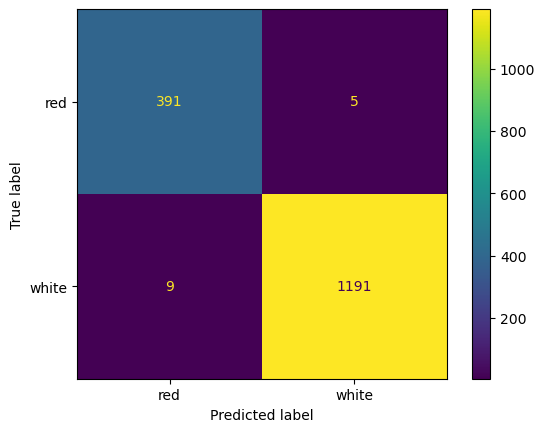

In [18]:
print("Accuracy score on test data", random_search.score(X_test, y_test))

# print confusion matrix
ConfusionMatrixDisplay.from_estimator(
    random_search,
    X_test,
    y_test,
    values_format="d"
);

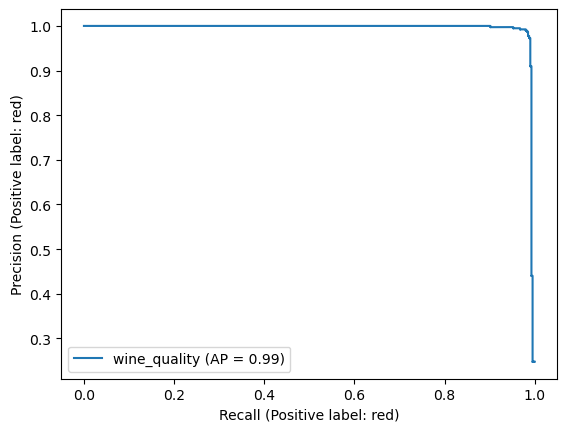

In [19]:
PrecisionRecallDisplay.from_estimator(
    random_search,
    X_test,
    y_test,
    pos_label="red",
    name='wine_quality', 
)

___
### DISCUSSION
___
From the results above, we see that the logistic regression with balanced class weight performs very well in the validation set as it scores more than 0.98 for all metrics, showing both a high performance in accuracy and much less classification bias due to very high recall and precision scores. Since the validation accuracy score is very high (>0.994), we decide to do a further randomized search cross-validation using the F1 score to find an optimized hyperparameter C that can minimize our classification bias.  

Using the optimized model on the test data, we see that the model has a high accuracy score as well (0.985). Moreover, from the confusion matrix, we see that there are very few false positives (false red) and false negatives (false white) compared to the true ones. This implies that the recall and precision scores are near 1 on the test data. This is further supported by the precision-recall curve as the average precision is 0.99 and the precision score maintains constantly very close to 1 when adjusting the threshold in the model.  

With the results being near perfect with the predictions on the test data, this is out of our expectations as we would expect there will be a more flawed prediction that will not perform as great in both recall and precision in general (especially not when both recall and precision are higher than 0.98). 

The near perfect scores in the test data suggest that our model will probably do a great job in predicting the wine type given any new data. However, we also have to bear in mind that the possibility that the model might not perform as well on actual unseen data. These very high scores are quite alarming that we might have to worry that it somehow overfits on both our train and test data and cannot generalize over new unseen data.  

___
### REFERENCES
___

Wine Quality [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C56S3T.

Dua, Dheeru, and Casey Graff. 2017. “UCI Machine Learning Repository.” University of California, Irvine, School of Information; Computer Sciences. http://archive.ics.uci.edu/ml.

Harris, C.R. et al., 2020. Array programming with NumPy. Nature, 585, pp.357–362.

Jed Wing, Max Kuhn. Contributions from, Steve Weston, Andre Williams, Chris Keefer, Allan Engelhardt, Tony Cooper, Zachary Mayer, et al. 2019. Caret: Classification and Regression Training. https://CRAN.R-project.org/package=caret.

Reitz, Kenneth. 2011. Requests: HTTP for Humans. https://requests.readthedocs.io/en/master/.

VanderPlas, J. et al., 2018. Altair: Interactive statistical visualizations for python. Journal of open source software, 3(32), p.1057.

Van Rossum, Guido, and Fred L. Drake. 2009. Python 3 Reference Manual. Scotts Valley, CA: CreateSpace.